<a href="https://colab.research.google.com/github/HaiAnh-X/Introduction-to-Deep-Learning-Optimizing-CNNs-for-MNIST-Classification/blob/main/Interpretability_of_Machine_Learning_Algorithms_Alzheimer's_Application.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Interpretability of Machine Learning algorithms @ 2021
  ### Mohamed Ibn Khedher & Mounim A. El-Yacoubi

**SHAP (SHapley Additive exPlanations)**

SHAP (SHapley Additive exPlanations) by Lundberg and Lee (2016) [1] is a method to explain individual predictions. SHAP is based on the game theoretically optimal Shapley Values.

The goal of SHAP is to explain the prediction of an instance x by computing the contribution of each feature to the prediction. The SHAP explanation method computes Shapley values from coalitional game theory. The feature values of a data instance act as players in a coalition. Shapley values tell us how to fairly distribute the “payout” (= the prediction) among the features. A player can be an individual feature value, e.g. for tabular data. A player can also be a group of feature values. For example to explain an image, pixels can be grouped to super pixels and the prediction distributed among them. One innovation that SHAP brings to the table is that the Shapley value explanation is represented as an additive feature attribution method, a linear model. That view connects LIME and Shapley Values. SHAP specifies the explanation as:
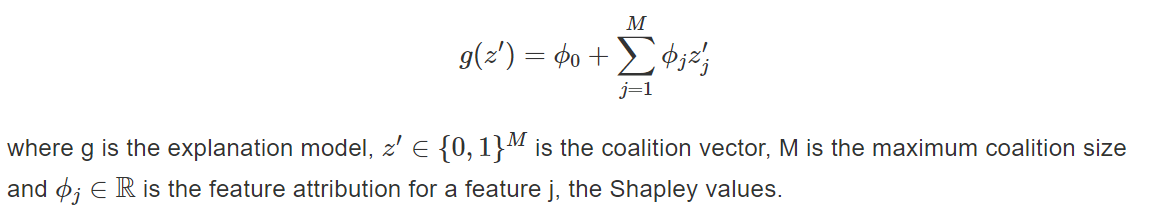

For more information about the technique SHAP and its variants, we invite you to consult the reference [2].

[1] Lundberg, Scott M., and Su-In Lee. “A unified approach to interpreting model predictions.” Advances in Neural Information Processing Systems. 2017.

[2]  https://christophm.github.io/interpretable-ml-book/shap.html#fn69

# The objective of this lab is to interpret the decisions taken by Machine Learning algorithms using the SHAP technique. We are studying the application of detecting whether the patient has alzhemer's disease or not.


## We considered the following ML algorithms
### 1. Decision Tree ([DT](https://scikit-learn.org/stable/modules/tree.html))
### 1. Random Forest ([RF](https://scikit-learn.org/stable/modules/ensemble.html))
### 3. XGBoost ([XGB](https://xgboost.readthedocs.io/en/latest/python/index.html))
### 4. Deep Learning (DL)


### **The first step before launching the notebook, it would be necessary manually upload the attached database file "oasis_longitudinal.csv" on colab.**

##**TODO:**
#### **shape_value is a matrix, the first matrix corresponding to the label to be explained and the second dimension corresponding to the input in the dataset.**
##### **For each classifier**
##### **1. Show and interpret the local explanation of some dataset inputs using shape_value[xxx][xxx]**
#### **2. Interpret the global explanation (over the entire dataset) already computed in this lab.**

## Import the needed packages

In [26]:
%matplotlib inline

import glob
import seaborn as sns
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
!pip install shap
import sklearn.tree
import shap
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import xgboost
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical

 # I) Read all the available dataset

This part consists of reading the OASIS dataset, splitting it into train and test sets and displaying a number of images per set.



In [27]:
df = pd.read_csv('oasis_longitudinal.csv')
#fillna will fill the missing data.
# https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.fillna.html

df = df.fillna(method = 'ffill')

#Calculate the number of samples per class
Counter(df["Group"])

# Display the last 5 lines..
df.tail()

# Display the first 5 lines.
df.head()

/tmp/ipython-input-2463037141.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method = 'ffill')


,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,2.0,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,2.0,28.0,0.5,1738,0.713,1.010
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,2.0,22.0,0.5,1698,0.701,1.034


# II) Extract the important feature and split data

In [28]:
df=df[['Group','M/F', 'Age', 'EDUC', 'SES',  'eTIV', 'ASF']]
#Encoding the Group variable
   # 'Not Demented' has become 2.
   # 'Demented' has become 1.

# Enconde the categorical features
for x in ['M/F', 'Age','Group']:
    f = LabelEncoder()
    df[x] = f.fit_transform(df[x])

df['Group'].replace(to_replace = 2, value = 0, inplace = True)
df['Group'].replace(to_replace = 1, value = 1, inplace = True)

# The dataset is splited as:
# 70% for training
# 30% for test

train, test = train_test_split(df, test_size = 0.3)

/tmp/ipython-input-1659479664.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Group'].replace(to_replace = 2, value = 0, inplace = True)
/tmp/ipython-input-1659479664.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplac

# II) Problem definition Y= f(X)
### We will predict the Group the M/F, Age, EDUC, SES, eTIV and ASF features.

In [29]:
X_train = train[['M/F', 'Age', 'EDUC', 'SES',  'eTIV', 'ASF']]
y_train = train.Group

X_test = test[['M/F', 'Age', 'EDUC', 'SES',  'eTIV',  'ASF']]
y_test = test.Group

# III) Data normalization

In [30]:
# Define the scaler
scaler = StandardScaler().fit(X_train)

# Scale the training dataset
X_train = scaler.transform(X_train)

# Scale the test dataset
X_test = scaler.transform(X_test)

#Transfor data to array
y_train = np.ravel(y_train)
X_train = np.asarray(X_train)

y_test = np.ravel(y_test)
X_test = np.asarray(X_test)

X_train_DF= pd.DataFrame(X_train,columns=["M/F", "Age","EDUC","SES","eTIV","ASF"])
X_test_DF= pd.DataFrame(X_test,columns=["M/F", "Age","EDUC","SES","eTIV","ASF"])

#IV) Decision Tree classifier.

### 1)  Train and evaluate a DT Classifier

In [31]:
dtree = sklearn.tree.DecisionTreeClassifier(min_samples_split=2)
dtree.fit(X_train, y_train)

print(dtree.score(X_train, y_train))
print(dtree.score(X_test, y_test))

1.0
0.7410714285714286


### 2)  Global interpreation of the DT classifier
**TODO: interpretate the obtained results**

  0%|          | 0/112 [00:00<?, ?it/s]

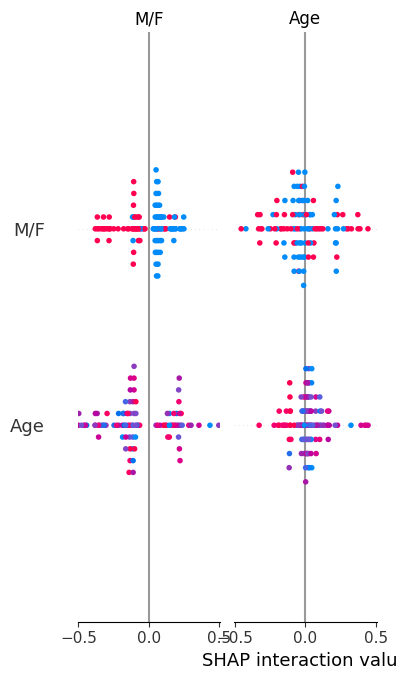

In [32]:
explainer = shap.KernelExplainer(dtree.predict_proba,X_train_DF)

#compute shap_values
shap_values = explainer.shap_values(X_test_DF, approximate=True)

# visualize the prediction's explanation
shap.summary_plot(shap_values, X_test_DF)

In [33]:
print(f"Shape of shap_values: {shap_values.shape}")
print(f"Shape of X_test_DF: {X_test_DF.shape}")

Shape of shap_values: (112, 6, 2)
Shape of X_test_DF: (112, 6)


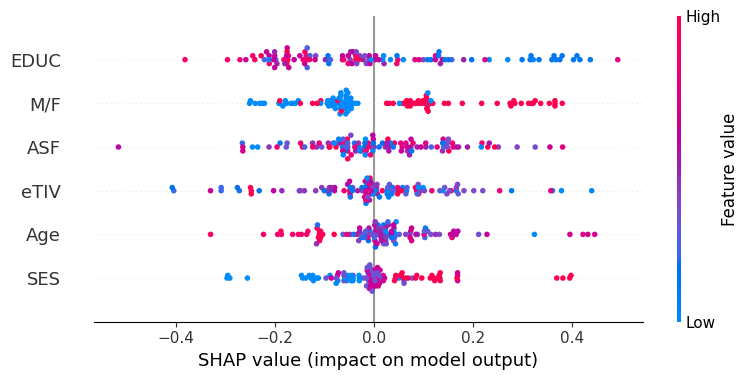

In [34]:
#Explanation according to one class (0 or 1)
shap.summary_plot(shap_values[:, :, 1], X_test_DF)

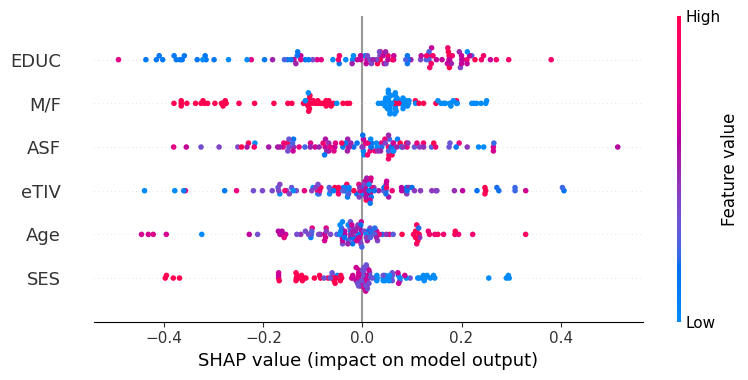

In [35]:
#Explanation according to one class (0 or 1)
shap.summary_plot(shap_values[:, :, 0], X_test_DF)

#V) Random Forest classifier.

### 1)  Train and evaluate a RF Classifier

In [36]:
rf = sklearn.ensemble.RandomForestClassifier(max_depth=50, random_state=0)
rf.fit(X_train, y_train)

print(rf.score(X_train, y_train))
print(rf.score(X_test, y_test))

1.0
0.875


### 2)  Global interpreation of the RF classifier
**TODO: interpretate the obtained results**

  0%|          | 0/112 [00:00<?, ?it/s]

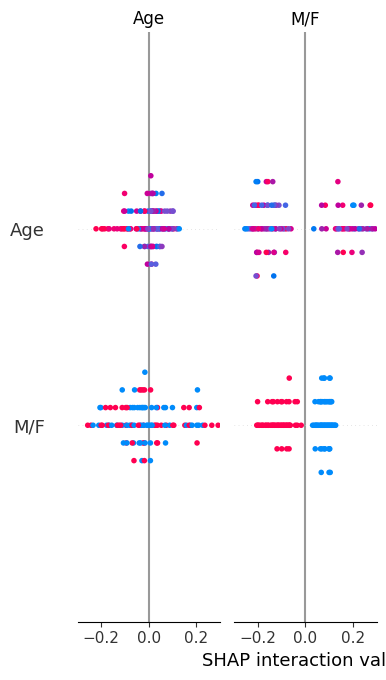

In [37]:
explainer = shap.KernelExplainer(rf.predict_proba,X_train_DF)

#Compute shap_values
shap_values = explainer.shap_values(X_test_DF, approximate=True)

# visualize the prediction's explanation
shap.summary_plot(shap_values, X_test_DF)

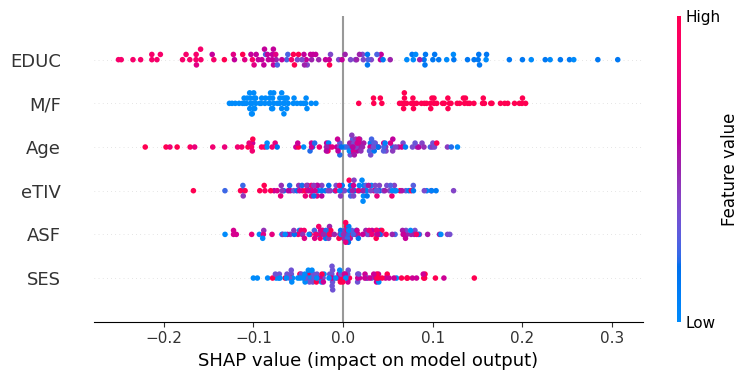

In [39]:
#Explanation according to one class (0 or 1)
shap.summary_plot(shap_values[:, :, 1], X_test_DF)

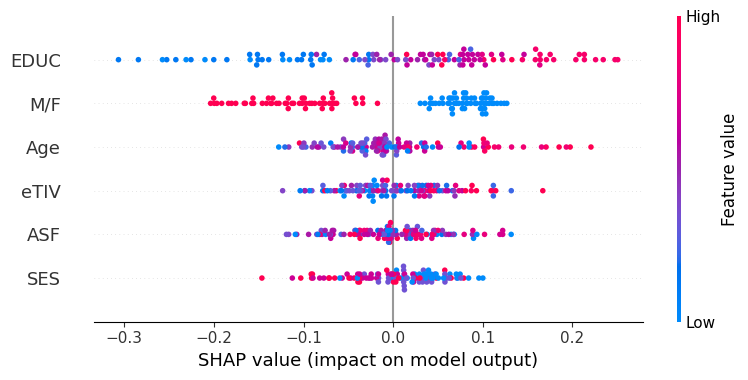

In [40]:
#Explanation according to one class (0 or 1)
shap.summary_plot(shap_values[:, :, 0], X_test_DF)

#VI) XGBoost classifier



### 1)  Train and evaluate a XGBoost Classifier

In [41]:
# train an XGBoost model
model = xgboost.XGBClassifier(max_depth=50).fit(X_train, y_train)

print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

1.0
0.8125


### 2)  Global interpreation of the XGBoost classifier
**TODO: interpretate the obtained results**

  0%|          | 0/112 [00:00<?, ?it/s]

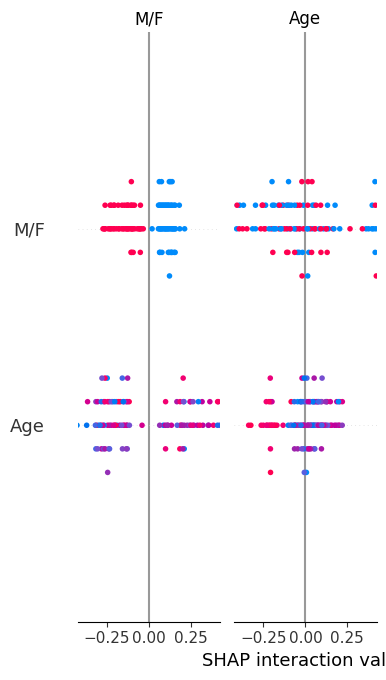

In [42]:
explainer = shap.KernelExplainer(model.predict_proba,X_train_DF)
shap_values = explainer.shap_values(X_test_DF)
#shap_values = explainer.shap_values(X_test_DF, approximate=True)
# visualize the first prediction's explanation
shap.summary_plot(shap_values, X_test_DF,feature_names=["M/F", "Age","EDUC","SES","eTIV","ASF"])

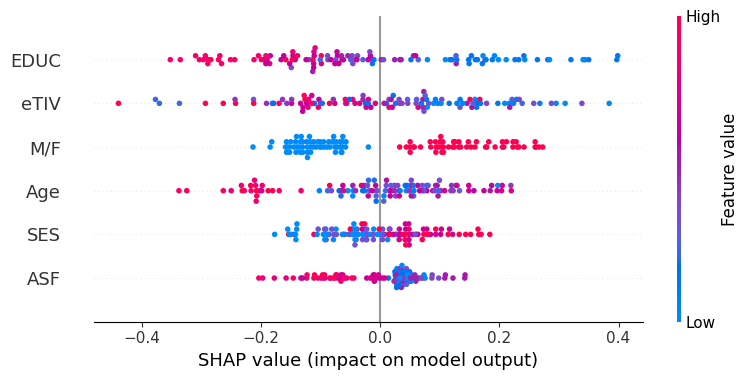

In [43]:
#Explanation according to one class (0 or 1)
shap.summary_plot(shap_values[:, :, 1], X_test_DF)

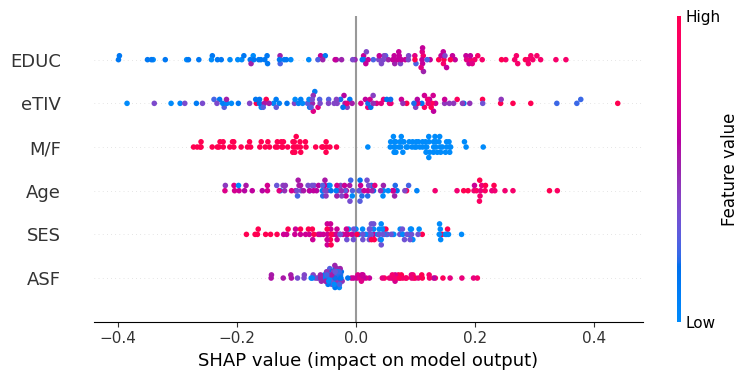

In [44]:
#Explanation according to one class (0 or 1)
shap.summary_plot(shap_values[:, :, 0], X_test_DF)

#VII) Deep Learning

### 1)  Define the architecture

In [45]:
#A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor.
model = Sequential()
model.add(Dense(32, input_shape=(6,), activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(4, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 4)              │            68 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │            10 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,598 (84.37 KB)

 Trainable params: 21,598 (84.37 KB)

 Non-trainable params: 0 (0.00 B)

### 2)  Train and evaluate a Deep Learning based  Classifier

In [50]:
y_test_cat = to_categorical(y_test, 2)
y_train_cat =to_categorical(y_train, 2)

X_train_np = np.asarray(X_train).astype('float32')
y_train_np = np.asarray(y_train_cat).astype('float32')
X_test_np = np.asarray(X_test).astype('float32')
y_test_np = np.asarray(y_test_cat).astype('float32')

with tf.device('/device:GPU:0'):
    model.fit(
        X_train_np,
        y_train_np,
        validation_split=0.3,
        epochs=100,
        verbose=1,
        batch_size=32
    )

# 4. Đánh giá mô hình trên GPU
with tf.device('/device:GPU:0'):
    loss, accuracy = model.evaluate(X_test_np, y_test_np)
    print(f"Test Accuracy: {accuracy:.4f}")

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.5741 - loss: 0.6718 - val_accuracy: 0.5949 - val_loss: 0.6757
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6028 - loss: 0.6726 - val_accuracy: 0.5949 - val_loss: 0.6692
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5622 - loss: 0.6660 - val_accuracy: 0.5949 - val_loss: 0.6620
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5439 - loss: 0.6632 - val_accuracy: 0.5949 - val_loss: 0.6537
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5665 - loss: 0.6387 - val_accuracy: 0.5949 - val_loss: 0.6505
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5997 - loss: 0.6121 - val_accuracy: 0.5949 - val_loss: 0.6527
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5925 - loss: 0.6095 - val_accuracy: 0.5949 - val_loss: 0.6509
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5658 - loss: 0.6336 - val_accuracy: 0.5949 - val_loss: 

### 2)  Global interpreation of the DL classifier
**TODO: interpretate the obtained results**

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step


  0%|          | 0/112 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step
506/506 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
506/506 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
506/506 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
506/506 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
506/506 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
506/506 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
506/506 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
506/506 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
506/506 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
506/506 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
506/506 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
506/506 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
506/506 ━━━━━

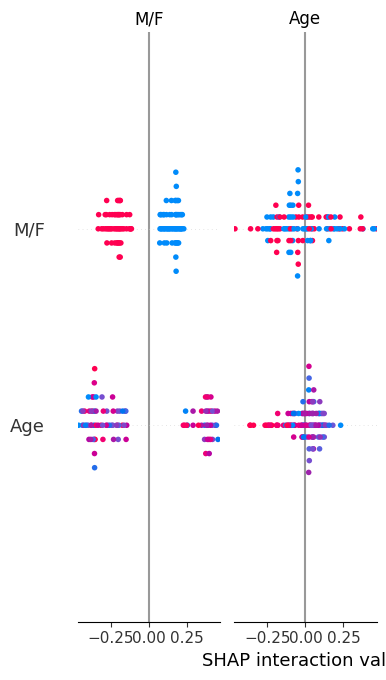

In [51]:
explainer = shap.KernelExplainer(model.predict,X_train_DF)
shap_values = explainer.shap_values(X_test_DF)

# visualize the first prediction's explanation with a summary plot
shap.summary_plot(shap_values, X_test_DF,feature_names=["M/F", "Age","EDUC","SES","eTIV","ASF"])

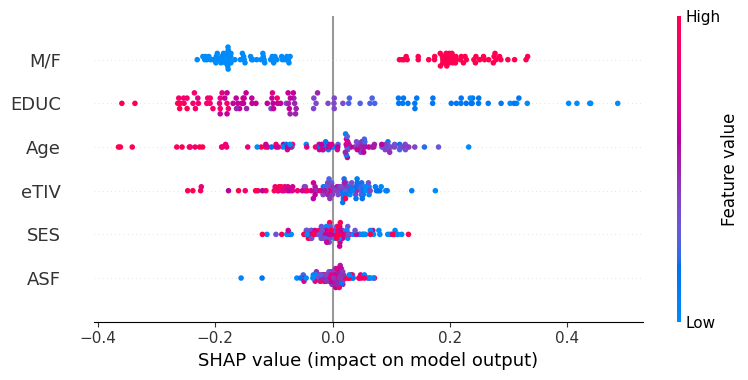

In [53]:
#Explanation according to one class (0 or 1)
shap.summary_plot(shap_values[:,:,1], X_test_DF,feature_names=["M/F", "Age","EDUC","SES","eTIV","ASF"])